# Regression analysis with SVD decomposition for a real covariance with a fake model

In [1]:
import pandas as pd
import numpy as np
from numpy.random import multivariate_normal, normal
from numpy.linalg import cholesky, svd
from scipy.sparse.linalg import lsqr
from itertools import accumulate
from sklearn.linear_model import LinearRegression
from scipy.linalg import lstsq
from scipy.optimize import nnls

import pytest

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sandy

## Real covariance with few groups (33)

In [4]:
tape = sandy.get_endf6_file("jeff_33", "xs", 922350)
mt = 102
err = tape.get_errorr(err=1, xs=True, nubar=False, chi=False, mubar=False, errorr33_kws=dict(mt=mt, ign=19), verbose=True)["errorr33"]
cov = err.get_cov()

INFO:  Zero or no temperature was requested, NJOY processing will stop after RECONR.
    If you want to process 0K cross sections use `temperature=0.1`.
    


moder
20 -21 /
reconr
-21 -22 /
'sandy runs njoy'/
9228 0 0 /
1.0 0. /
0/
moder
-22 30 /
errorr
-21 -22 0 33 0 /
9228 19 2 0 1 /
0 0.0 /
1 33 0/
1 0 /
102 /
stop

 njoy 2016.71  14Jul23                                       09/10/23 17:10:13
 *****************************************************************************

 moder...                                                                 0.0s

 reconr...                                                                0.1s

 ---message from rdf2bw---calculation of angular distribution not installed.

 moder...                                                                 9.4s

 errorr...                                                                9.9s

 ---message from errorr---neutron group structure option 19 has been
                          changed, you may want to use -1 instead

 processing mat  9228
 ---------------------
  92-U -235 IRSN-CEA   EVAL-DEC14 IRSN-CEA DAM/DEN COLLAB.           

 covariances calculated for 

In [5]:
C = cov.data.copy()
C = pd.DataFrame(C.values + np.diag(np.diag(C.values) * 0.5 / 100 + 0.0001), index=C.index, columns=C.columns)
cov_ = sandy.CategoryCov(C)
U, S, V = svd(C)
Lambda12 = np.diag(np.sqrt(S))
np.testing.assert_almost_equal((U @ Lambda12) @ (U @ Lambda12).T, C.values)

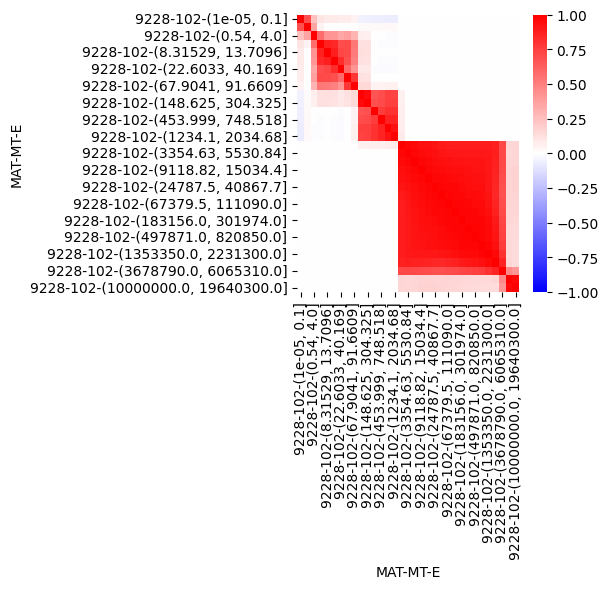

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cov_.get_corr().data, ax=ax, cmap="bwr", vmin=-1, vmax=1)
fig.tight_layout()

In [7]:
M = cov.data.shape[0]  # number of parameters

frac = S / S.sum()
acc = np.array(list(accumulate(frac)))
r = acc[acc < 0.98].size + 1

N = 5000  # number of samples

print(f"sample size:                  {N:>10}\nnumber of parameters:         {M:>10}\nreduced number of parameters: {r:>10}")

sample size:                        5000
number of parameters:                 33
reduced number of parameters:         14


In [8]:
# non correlated, standardized sample
X_ = normal(loc=1., scale=1., size=N * M).reshape(N, M)

# correlated sample
X = X_ @ (U @ Lambda12).T

In [9]:
f = (np.arange(M) + 1)[::-1]
def model(x): return f @ x

In [10]:
Y = model(X.T)
Z = lstsq(X, Y)[0]
#u, s, vh = svd(X, full_matrices=False)
#Z1 = (vh.T @ np.diag(1/s) @ u.T @ Y.reshape(-1, 1)).flatten()  # svd decomposition, same as in lstsq

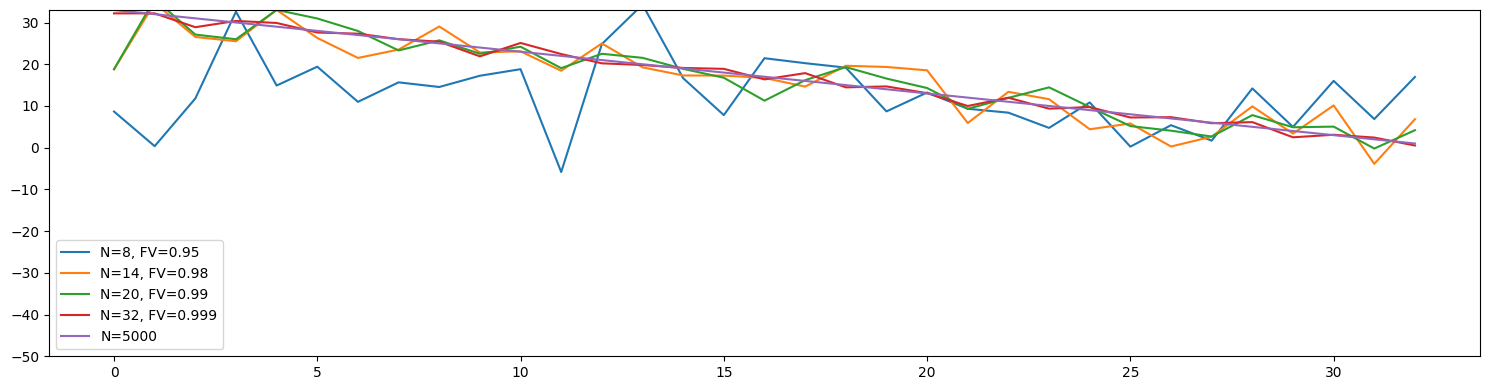

In [11]:
fig, ax = plt.subplots(figsize=(15, 4))

data = {}
for fv in np.array([0.95, 0.98, 0.99, 0.999]):
    n = acc[acc < fv].size + 1
    Y = model(X[:n, :].T)
    Z = lstsq(X[:n, :], Y)[0]
    data[f"N={n}, FV={fv}"] = Z

Y = model(X.T)
Z = lstsq(X, Y)[0]
data[f"N={N}"] = Z

pd.DataFrame(data).plot(kind="line", ax=ax)
ax.set(
    ylim=[-50, f.max()]
)

fig.tight_layout()

## Real covariance with many groups (1968)

In [12]:
tape = sandy.get_endf6_file("jeff_33", "xs", 922350)
mt = 102
err = tape.get_errorr(err=1, xs=True, nubar=False, chi=False, mubar=False, errorr33_kws=dict(mt=mt, ign=20), verbose=True)["errorr33"]
cov = err.get_cov()

INFO:  Zero or no temperature was requested, NJOY processing will stop after RECONR.
    If you want to process 0K cross sections use `temperature=0.1`.
    


moder
20 -21 /
reconr
-21 -22 /
'sandy runs njoy'/
9228 0 0 /
1.0 0. /
0/
moder
-22 30 /
errorr
-21 -22 0 33 0 /
9228 20 2 0 1 /
0 0.0 /
1 33 0/
1 0 /
102 /
stop

 njoy 2016.71  14Jul23                                       09/10/23 17:10:26
 *****************************************************************************

 moder...                                                                 0.0s

 reconr...                                                                0.1s

 ---message from rdf2bw---calculation of angular distribution not installed.

 moder...                                                                 9.4s

 errorr...                                                                9.9s

 processing mat  9228
 ---------------------
  92-U -235 IRSN-CEA   EVAL-DEC14 IRSN-CEA DAM/DEN COLLAB.           

 covariances calculated for  1 reactions and 1968 groups                 10.6s
                                                                         13.8s
 *****

In [13]:
C = cov.data.copy()
C = pd.DataFrame(C.values + np.diag(np.diag(C.values) * 0.5 / 100 + 0.0001), index=C.index, columns=C.columns)
cov_ = sandy.CategoryCov(C)
U, S, V = svd(C)
Lambda12 = np.diag(np.sqrt(S))
np.testing.assert_almost_equal((U @ Lambda12) @ (U @ Lambda12).T, C.values)

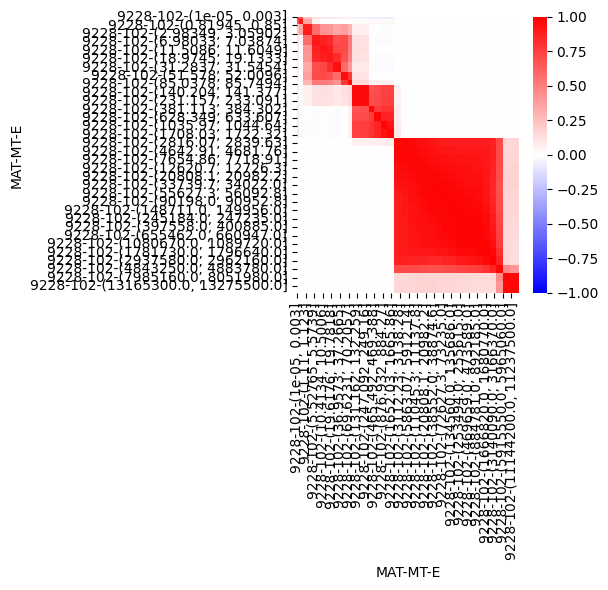

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cov_.get_corr().data, ax=ax, cmap="bwr", vmin=-1, vmax=1)
fig.tight_layout()

In [15]:
M = cov.data.shape[0]  # number of parameters

frac = S / S.sum()
acc = np.array(list(accumulate(frac)))
r = acc[acc < 0.98].size + 1

N = 5000  # number of samples

print(f"sample size:                  {N:>10}\nnumber of parameters:         {M:>10}\nreduced number of parameters: {r:>10}")

sample size:                        5000
number of parameters:               1968
reduced number of parameters:        212


In [16]:
# non correlated, standardized sample
X_ = normal(loc=1., scale=1., size=N * M).reshape(N, M)

# correlated sample
X = X_ @ (U @ Lambda12).T

In [17]:
f = (np.arange(M) + 1)[::-1]
def model(x): return f @ x

In [18]:
#u, s, vh = svd(X, full_matrices=False)
#Z1 = (vh.T @ np.diag(1/s) @ u.T @ Y.reshape(-1, 1)).flatten()  # svd decomposition, same as in lstsq

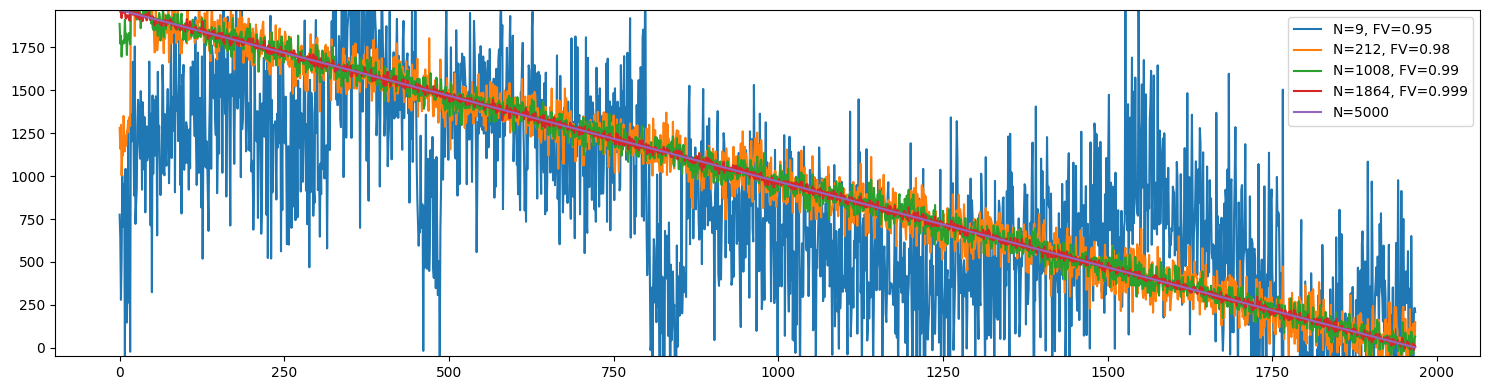

In [19]:
fig, ax = plt.subplots(figsize=(15, 4))

data = {}
for fv in np.array([0.95, 0.98, 0.99, 0.999]):
    n = acc[acc < fv].size + 1
    Y = model(X[:n, :].T)
    Z = lstsq(X[:n, :], Y)[0]
    data[f"N={n}, FV={fv}"] = Z

Y = model(X.T)
Z = lstsq(X, Y)[0]
data[f"N={N}"] = Z

pd.DataFrame(data).plot(kind="line", ax=ax)
ax.set(
    ylim=[-50, f.max()]
)

fig.tight_layout()

## Real covariance with many groups (239) and many reactions (all=8)

In [20]:
tape = sandy.get_endf6_file("jeff_33", "xs", 922350)
mt = 102
err = tape.get_errorr(err=1, xs=True, nubar=False, chi=False, mubar=False, errorr33_kws=dict(ign=2), verbose=True)["errorr33"]
cov = err.get_cov()

INFO:  Zero or no temperature was requested, NJOY processing will stop after RECONR.
    If you want to process 0K cross sections use `temperature=0.1`.
    


moder
20 -21 /
reconr
-21 -22 /
'sandy runs njoy'/
9228 0 0 /
1.0 0. /
0/
moder
-22 30 /
errorr
-21 -22 0 33 0 /
9228 2 2 0 1 /
0 0.0 /
0 33 0/
stop

 njoy 2016.71  14Jul23                                       09/10/23 17:11:01
 *****************************************************************************

 moder...                                                                 0.0s

 reconr...                                                                0.1s

 ---message from rdf2bw---calculation of angular distribution not installed.

 moder...                                                                 9.3s

 errorr...                                                               10.0s

 processing mat  9228
 ---------------------
  92-U -235 IRSN-CEA   EVAL-DEC14 IRSN-CEA DAM/DEN COLLAB.           

 covariances calculated for  8 reactions and  248 groups                 10.6s
                                                                         13.4s
 ******************

In [21]:
C = cov.data.copy()
print(f"condition number original matrix: {np.linalg.cond(C):>10}")
C = pd.DataFrame(C.values + np.diag(np.diag(C.values) * 0.5 / 100 + 0.0001), index=C.index, columns=C.columns)
print(f"condition number adjusted matrix: {np.linalg.cond(C):>10}")
cov_ = sandy.CategoryCov(C)
U, S, V = svd(C)
Lambda12 = np.diag(np.sqrt(S))
np.testing.assert_almost_equal((U @ Lambda12) @ (U @ Lambda12).T, C.values)

condition number original matrix:        inf
condition number adjusted matrix: 26609.385969160914


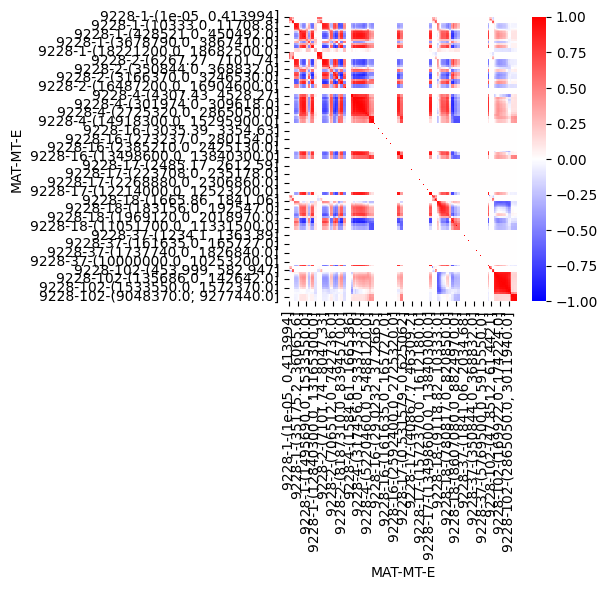

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cov_.get_corr().data, ax=ax, cmap="bwr", vmin=-1, vmax=1)
fig.tight_layout()

In [23]:
M = cov.data.shape[0]  # number of parameters

frac = S / S.sum()
acc = np.array(list(accumulate(frac)))
r = acc[acc < 0.98].size + 1

N = 5000  # number of samples

print(f"sample size:                  {N:>10}\nnumber of parameters:         {M:>10}\nreduced number of parameters: {r:>10}")

sample size:                        5000
number of parameters:               1920
reduced number of parameters:        856


In [24]:
# non correlated, standardized sample
X_ = normal(loc=1., scale=1., size=N * M).reshape(N, M)

# correlated sample
X = X_ @ (U @ Lambda12).T

In [25]:
f = (np.arange(M) + 1)[::-1]
def model(x): return f @ x

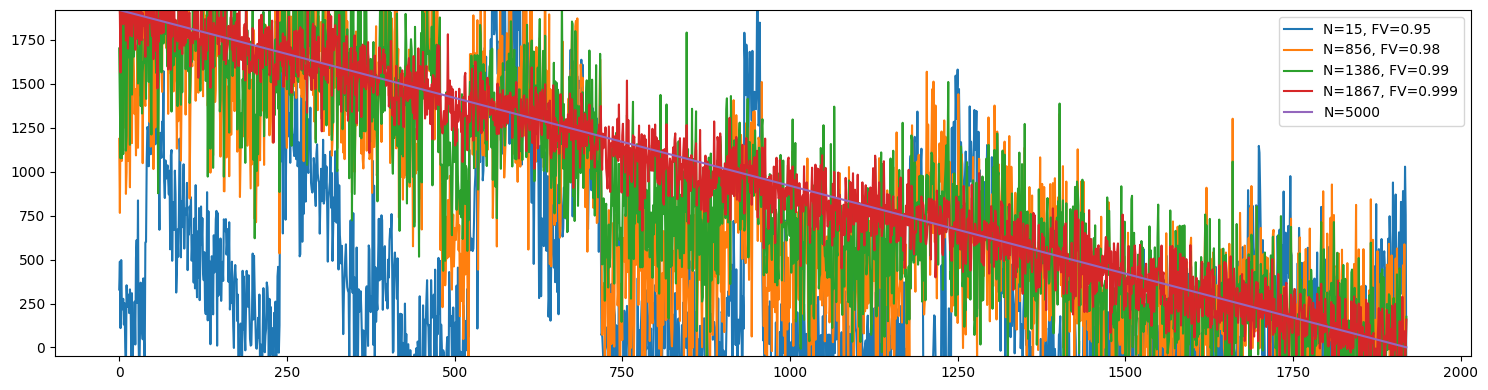

In [26]:
fig, ax = plt.subplots(figsize=(15, 4))

data = {}
for fv in np.array([0.95, 0.98, 0.99, 0.999]):
    n = acc[acc < fv].size + 1
    Y = model(X[:n, :].T)
    Z = lstsq(X[:n, :], Y)[0]
    data[f"N={n}, FV={fv}"] = Z

Y = model(X.T)
Z = lstsq(X, Y)[0]
data[f"N={N}"] = Z

pd.DataFrame(data).plot(kind="line", ax=ax)
ax.set(
    ylim=[-50, f.max()]
)

fig.tight_layout()